# NEON

This notebook is an excercise in executing ISOFIT on two dates from the NEON dataset and interpreting the outputs of ISOFIT.

Prerequisites:
- Have ISOFIT installed and sRTMnet configured.
- Download the [sample data](https://avng.jpl.nasa.gov/pub/PBrodrick/isofit/tutorials/subset_data.zip) and place the unzipped `data` directory into the same directory of this notebook.

Note: If you downloaded the [ISOFIT extra data](https://isofit.readthedocs.io/en/latest/custom/data.html) via `isofit download`, both sRTMnet and the NEON data files will be installed correctly and available with default settings for this notebook.

In [1]:
# Jupyter magics
%matplotlib inline

In [2]:
# Builtin
import os
import shutil
from types import SimpleNamespace

# External
import matplotlib.pyplot  as plt
import matplotlib.patches as patches
import numpy as np
from spectral.io import envi

# Internal
import isofit
from isofit.data import env
from isofit.utils.apply_oe import apply_oe 
from isofit.utils.surface_model import surface_model


In [3]:
# Below are the default values for the ISOFIT environment. Change these if your environment differs

env.load('~/.isofit/isofit.ini') # Ini file to load
env.changeSection('DEFAULT')     # Section of the ini to use
# env.changeBase('~./isofit')      # Base path for ISOFIT extras (data, examples, etc)
# env.changePath('srtmnet', '/path/to/sRTMnet_v120.h5') # Overwrite the path to sRTMnet - copy this line for other products such as sixs if in non-default locations

print('Using environment paths:')
for key, path in env.items():
    print(f"- {key} = {path}") 


Using environment paths:
- data = /home/mambauser/data
- examples = /home/mambauser/examples
- imagecube = /home/mambauser/imagecube
- srtmnet = /home/mambauser/srtmnet
- sixs = /home/mambauser/sixs
- modtran = /home/mambauser/modtran


## Setup

ISOFIT needs at minimum three pieces as input:

    1. Radiance measurements (rdn)
    2. Observation values    (obs)
    3. Location information  (loc)

This sample dataset from NEON has radiance and observation data, but no location values (more recent NEON datasets include the location file).  However, we can 'fake' the location file with sufficient accuracy for ISOFIT to run successfully.  Note that there are data available for two dates:

```
Radiance
├── 173647
│   ├── NIS01_20210403_173647_obs_ort
│   ├── NIS01_20210403_173647_obs_ort.hdr
│   ├── NIS01_20210403_173647_rdn_ort
│   └── NIS01_20210403_173647_rdn_ort.hdr
└── 174150
    ├── NIS01_20210403_174150_obs_ort
    ├── NIS01_20210403_174150_obs_ort.hdr
    ├── NIS01_20210403_174150_rdn_ort
    └── NIS01_20210403_174150_rdn_ort.hdr
```

These files have corresponding in situ data as well, and below we've encoded the locations of each, which we can use to help subset data files.


In [4]:
from utils.neon import report

# Which NEON date to process - change this to process a different date
neon_id  = list(report.keys())[0]
neon_str = f"NIS01_20210403_{neon_id}"

# Select the locations from the neon id -- roi == Regions of Interest
roi = report[neon_id]

from types import SimpleNamespace
from pathlib import Path

# Set the paths for this tutorial
base = Path(env.path('examples', 'NEON'))
data = base / 'data'

paths = SimpleNamespace(
    rdn = str(data / f'{neon_str}_rdn_ort'),
    loc = str(data / f'{neon_str}_loc_ort'),
    obs = str(data / f'{neon_str}_obs_ort'),
    insitu = data / 'FieldSpectrometer',
    output = base / 'output',
    working = base / f'output/NIS01_20210403_{neon_id}',
    surface = str(base / 'output/surface.mat'),
    surface_config = env.path('examples', '20171108_Pasadena', 'configs', 'ang20171108t184227_surface.json')
)

paths.output.mkdir(exist_ok=True, parents=True)

In [21]:
# If you are missing either an OBS file or a LOC file, use these to create faked versions based off the radiance file
# This should not be needed if using the provided data
# Using this may cause the below plots to not generate the same results

# from utils import faker

# paths.obs = faker.fakeOBS(
    # f"{paths.rdn}.hdr",
    # sea = 153.4481201171875,
    # sez = 178.3806858062744,
    # soa = 39.8218994140625,
    # soz = 39.8218994140625,
    # slope = 31.813383102416992
# )[:-4] # Remove the .hdr extension from the return
# paths.loc = faker.fakeLOC(
#     rdn = f"{paths.rdn}.hdr",
#     lon = -105.237000,
#     lat = 40.125000,
#     elv = 1689.0
# )[:-4]

# Apply OE

The next part walks through running the ISOFIT utility script `isofit/utils/apply_oe.py`. This is the first step of executing ISOFIT and will generate a default configuration.

In [5]:
# First build a surface model
surface_model(
    config_path = paths.surface_config,
    output_path = paths.surface,
    wavelength_path = f"{paths.rdn}.hdr"
)

0 ['/home/mambauser/data/reflectance/surface_model_ucsb']
1 ['/home/mambauser/data/reflectance/surface_model_ucsb']
2 ['/home/mambauser/data/reflectance/surface_model_ucsb']
3 ['/home/mambauser/data/reflectance/surface_model_ucsb']
4 ['/home/mambauser/data/reflectance/surface_model_ucsb']
5 ['/home/mambauser/data/reflectance/surface_model_ucsb']
6 ['/home/mambauser/data/reflectance/surface_model_ucsb']
7 ['/home/mambauser/data/reflectance/surface_model_ucsb']


In [6]:
# For reference, all of the available parameters to the apply_oe script
help(apply_oe)

Help on function apply_oe in module isofit.utils.apply_oe:

apply_oe(input_radiance, input_loc, input_obs, working_directory, sensor, surface_path, copy_input_files=False, modtran_path=None, wavelength_path=None, surface_category='multicomponent_surface', aerosol_climatology_path=None, rdn_factors_path=None, atmosphere_type='ATM_MIDLAT_SUMMER', channelized_uncertainty_path=None, model_discrepancy_path=None, lut_config_file=None, multiple_restarts=False, logging_level='INFO', log_file=None, n_cores=1, presolve=False, empirical_line=False, analytical_line=False, ray_temp_dir='/tmp/ray', emulator_base=None, segmentation_size=40, num_neighbors=[], atm_sigma=[2], pressure_elevation=False, prebuilt_lut=None, no_min_lut_spacing=False, inversion_windows=None)
    Applies OE over a flightline using a radiative transfer engine. This executes
    ISOFIT in a generalized way, accounting for the types of variation that might be
    considered typical.
    
    Observation (obs) and location (loc) f

In [7]:
# Add a ray shutdown, just in case this is being re-called
import ray
ray.shutdown()

# Cleanup any previous runs; comment this out if you want to preserve a previous run's output
if Path(paths.working).exists():
    shutil.rmtree(paths.working)

apply_oe(
    input_radiance    = paths.rdn, # Radiance
    input_loc         = paths.loc, # Location
    input_obs         = paths.obs, # Observations
    working_directory = str(paths.working), # Output directory
    sensor            = "neon", 
    surface_path      = paths.surface, # Surface priors - often changes
    emulator_base     = f"{env.srtmnet}/sRTMnet_v120.h5",
    surface_category  = "multicomponent_surface",

    modtran_path    = None,
    atmosphere_type = "ATM_MIDLAT_SUMMER", # MODTRAN
    aerosol_climatology_path = None,       # MODTRAN
    
    rdn_factors_path       = None, # RCC update used 'on the fly'
    model_discrepancy_path = None, # Model discrepancy term - handle things like unknown radiative transfer model effects
    channelized_uncertainty_path = None, # Channelized uncertainty - if you have an instrument model

    multiple_restarts = False, # Useful if the AOD conditions are really challenging
    
    presolve        = True,  # Attempts to solve for the right wv range
    empirical_line  = False, # wavelength-specific local linear interpolation between radiance and reflectance
    analytical_line = True,  # mathematical representation of OE given that the atmsophere is known
    
    segmentation_size  = 10,
    num_neighbors      = [5],
    atm_sigma          = [0.5, 0.5],
    pressure_elevation = False,

    n_cores = os.cpu_count(),
)

2024-11-20 23:30:40,305	INFO worker.py:1819 -- Started a local Ray instance.
INFO:2024-11-20,23:30:40 || apply_oe.py:apply_oe() | Checking input data files...
INFO:2024-11-20,23:30:40 || apply_oe.py:apply_oe() | ...Data file checks complete
INFO:2024-11-20,23:30:40 || apply_oe.py:apply_oe() | Setting up files and directories....
INFO:2024-11-20,23:30:40 || template_construction.py:__init__() | Flightline ID: NIS01_20210403_173647
INFO:2024-11-20,23:30:40 || template_construction.py:__init__() | no noise path found, proceeding without
INFO:2024-11-20,23:30:40 || template_construction.py:stage_files() | Staging /home/mambauser/examples/NEON/output/surface.mat to /home/mambauser/examples/NEON/output/NIS01_20210403_173647/data/surface.mat
INFO:2024-11-20,23:30:40 || apply_oe.py:apply_oe() | ...file/directory setup complete
INFO:2024-11-20,23:30:40 || apply_oe.py:apply_oe() | Using inversion windows: [[350.0, 1360.0], [1410, 1800.0], [1970.0, 2500.0]]
INFO:2024-11-20,23:30:40 || apply_oe.py

# Plotting

Below plots the regions of interest defined by a NEON report. 

In [8]:
# Load in the ISOFIT reflectance output
ds = envi.open(paths.working / f"output/{neon_str}_rfl.hdr")
rfl = ds.open_memmap(interleave='bip')
rgb = rfl[:, :, [60, 40, 30]].copy()
wl = np.array(ds.metadata['wavelength'], dtype=float)

# Find the bounding box for all regions of interest (RoI)
regions = report[neon_id]
bounds = np.vstack(list(regions.values()))
y = bounds[:, 0].min() - 5 # , bounds[:, 1].max() + 5
x = bounds[:, 2].min() - 5 # , bounds[:, 3].max() + 5


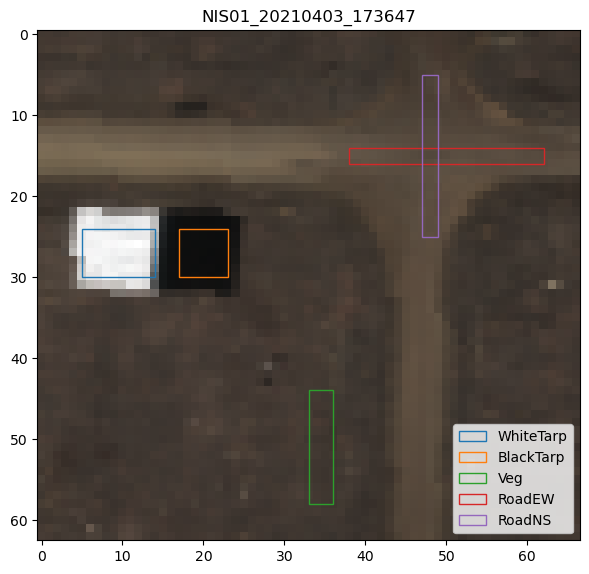

In [9]:
# Plot the RoIs
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(rgb / np.max(rgb, axis=(0, 1))) # Dividing brightens the image
ax.set_title(neon_str)

for i, (roi, region) in enumerate(regions.items()):
    rect = patches.Rectangle(
        (region[2] - x, region[0] - y), 
        region[3] - region[2], 
        region[1] - region[0], 
        linewidth = 1, 
        edgecolor = f'C{i}', 
        facecolor = 'none',
        label = roi
    )
    ax.add_patch(rect)
ax.legend(loc='lower right')

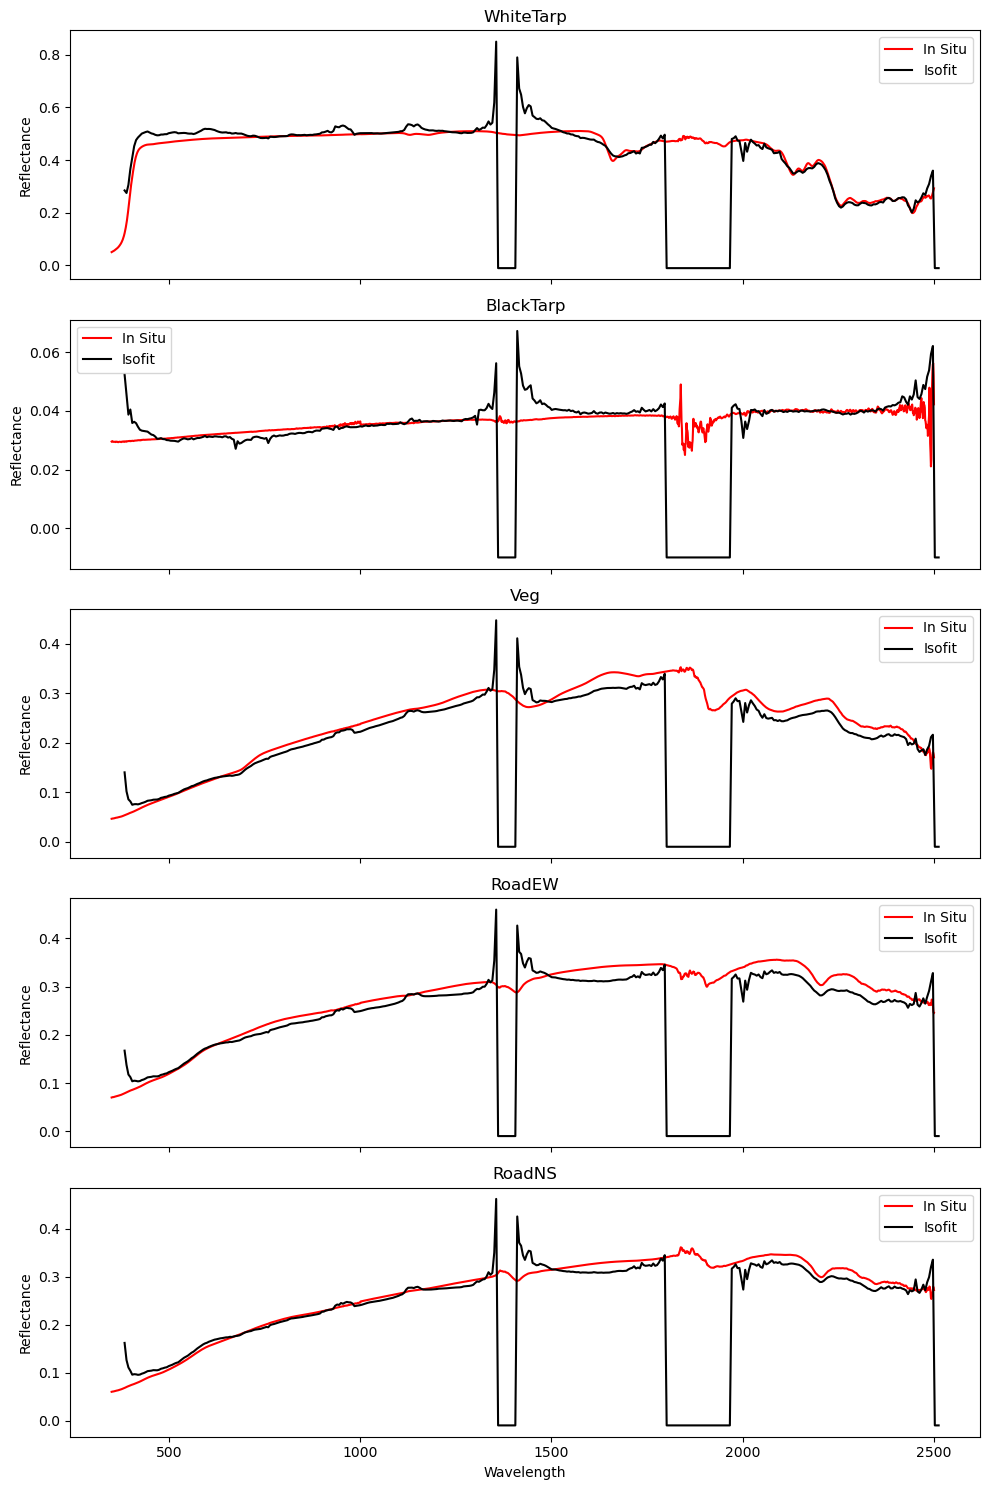

In [10]:
fig, axes = plt.subplots(len(regions), sharex=True, figsize=(10, 3*len(regions)))

for i, (roi, region) in enumerate(regions.items()):
    ax = axes[i]
    
    in_situ = np.genfromtxt(paths.insitu / f'{roi}01/Data/{roi}01_Refl.dat', skip_header=3)
    ax.plot(in_situ[:, 0], in_situ[:, 1], label='In Situ', c='red', ls='-')

    mean_rfl = np.mean(
        rfl[
            region[0] - y : region[1] - y,
            region[2] - x : region[3] - x,
        ],
        axis = (0, 1)
    )
    
    ax.plot(wl, mean_rfl, label='Isofit', c='black')
    
    ax.set_ylabel('Reflectance')
    ax.set_title(roi)
    ax.legend()

ax.set_xlabel('Wavelength')
plt.tight_layout()

We can plot out the mapped reflectance (as above), but also the interpolated atmospheric conditions.  The windows size is small enough here (and the atmospheric parameters are chosen in such a way) that the map is going to be pretty static...but we can still see it.

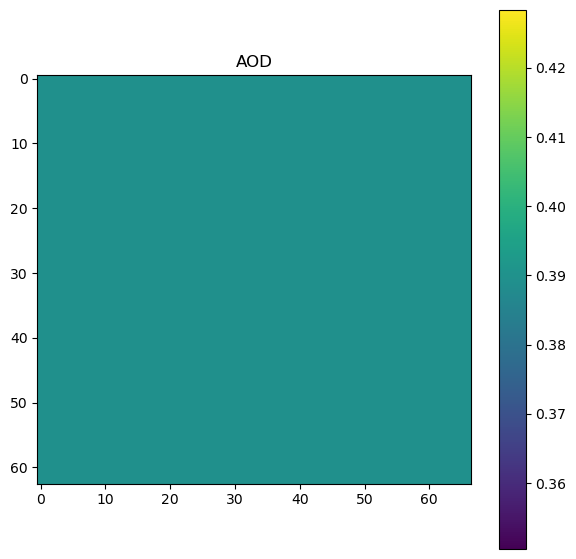

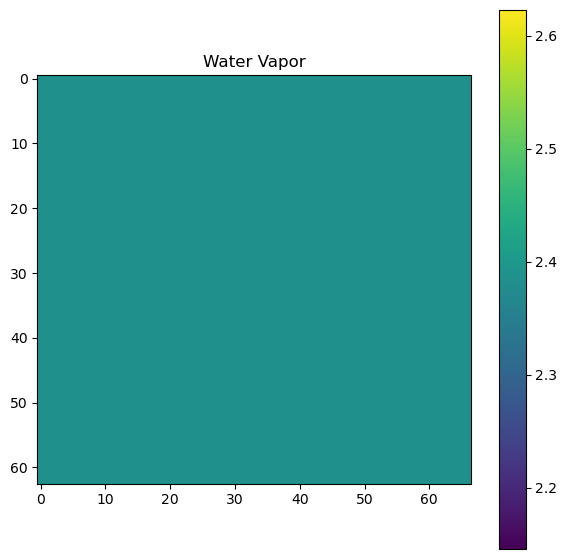

In [11]:
dat = envi.open(paths.working / f"output/{neon_str}_atm_interp.hdr")
atm = dat.open_memmap(interleave='bip').copy()

plt.figure(figsize=(7, 7))
plt.title('AOD')
plt.imshow(atm[..., 0])
plt.colorbar()

plt.figure(figsize=(7, 7))
plt.title('Water Vapor')
plt.imshow(atm[..., 1])
plt.colorbar()